# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
df = df = pd.read_csv('bikes_rent.csv')
print(df.head())
#print(df.)

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

season


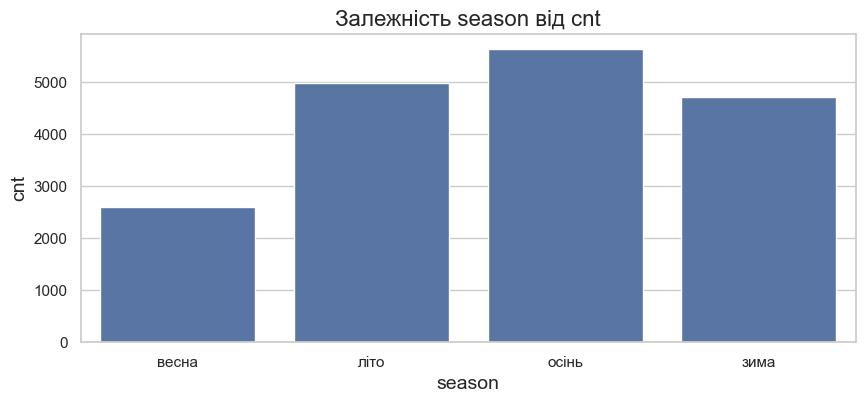

yr


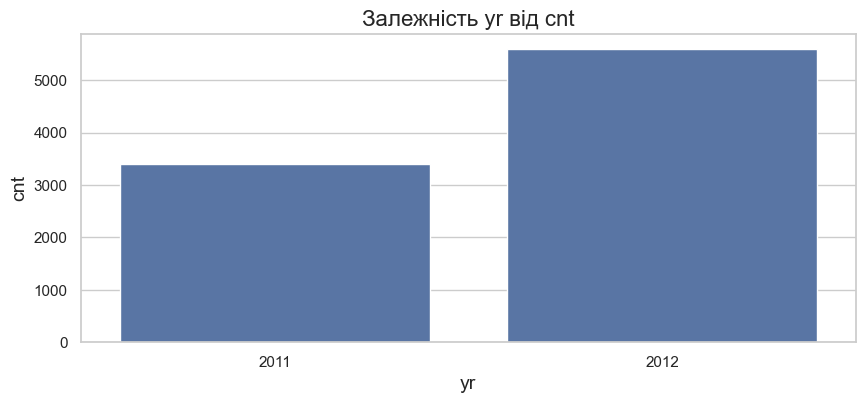

mnth


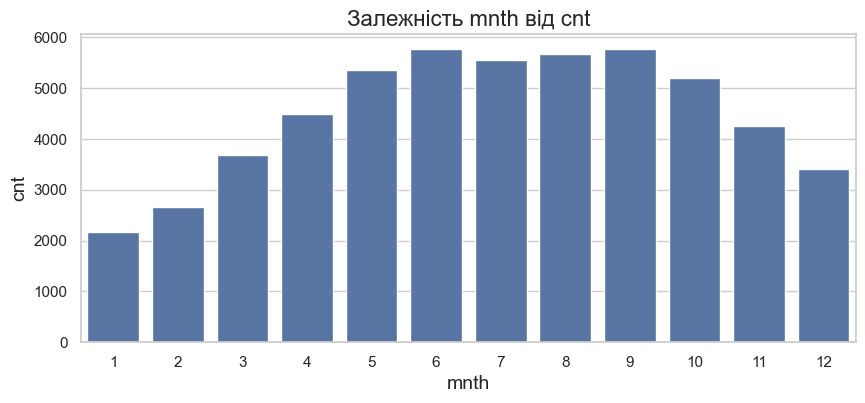

holiday


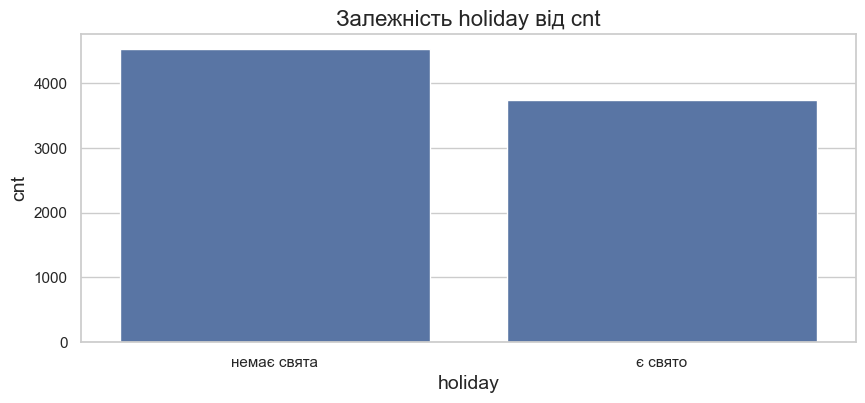

weekday


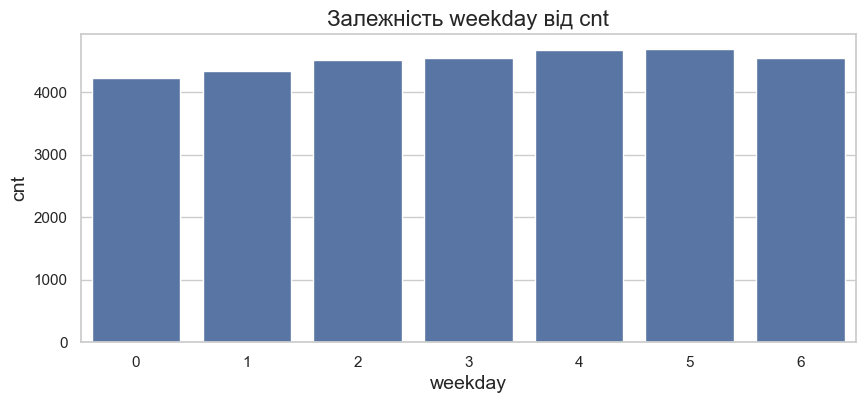

workingday


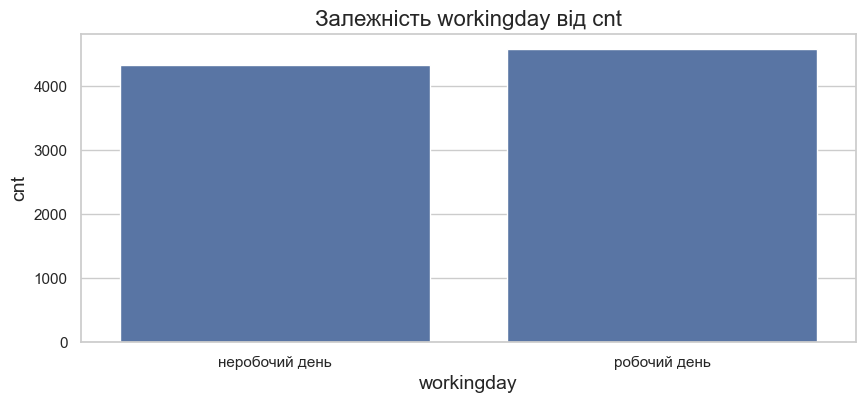

weathersit


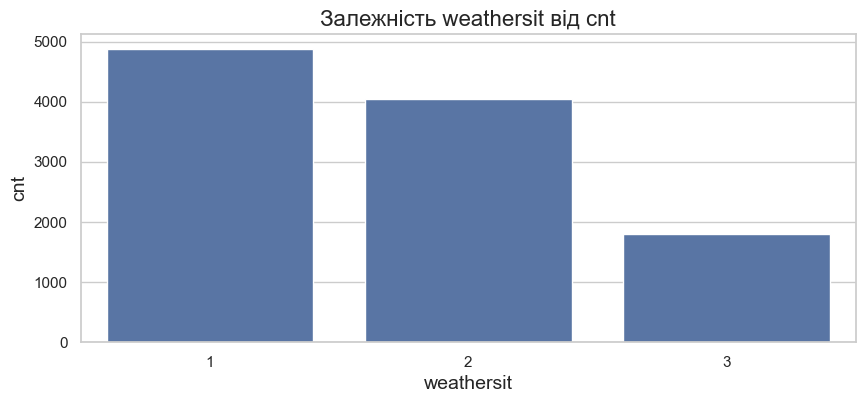

temp


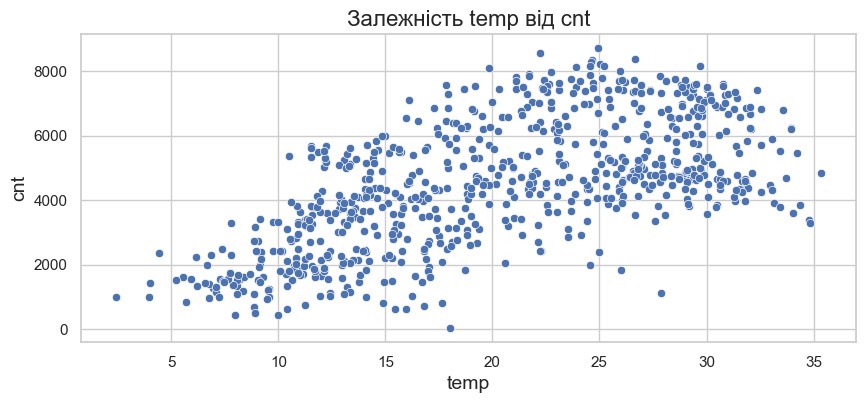

atemp


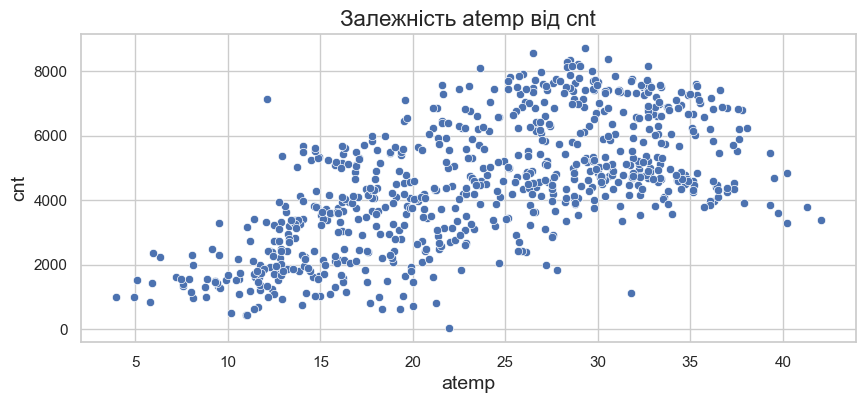

hum


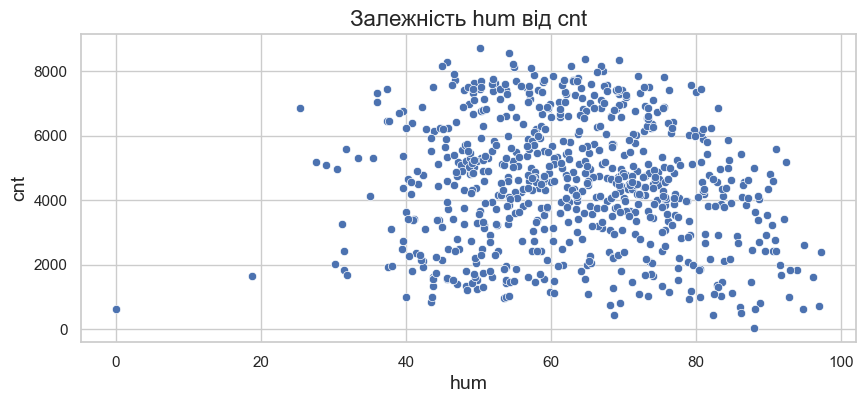

windspeed(mph)


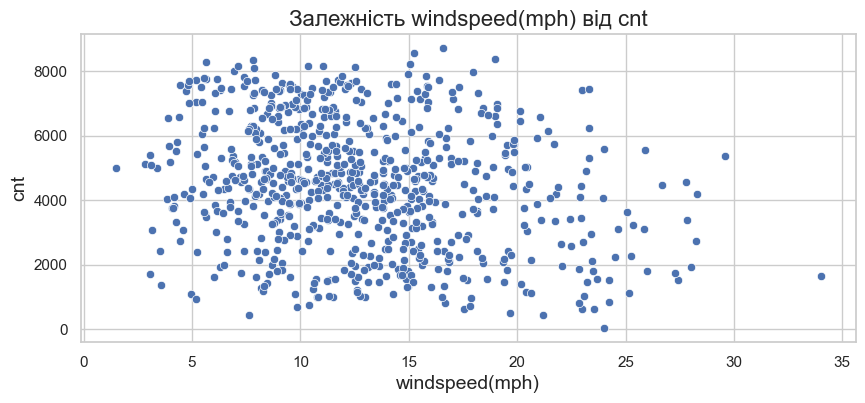

windspeed(ms)


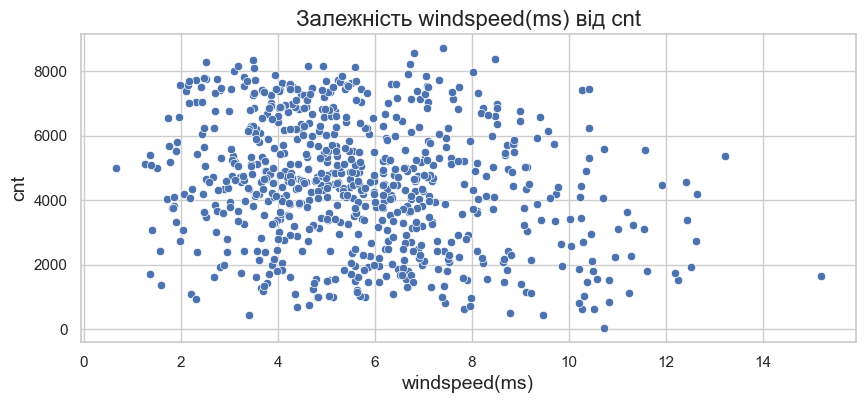

In [3]:
import seaborn as sns

df['season'] = df['season'].replace({1: "весна", 2:"літо", 3:"осінь", 4:"зима"})
df['yr'] = df['yr'].replace({0: 2011, 1: 2012})
df['holiday'] = df['holiday'].replace({0: "немає свята" , 1: "є свято"})
df['workingday'] = df['workingday'].replace({0: "неробочий день" , 1: "робочий день"})

features = df.columns[:-1]
sns.set(style="whitegrid")

for feature in features:
    print(feature)
    plt.figure(figsize=(10, 4))
    if feature in ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']:
        sns.barplot(x=df[feature], y=df['cnt'], errorbar=None) 
    else:
        # Для числових змінних використовуємо scatterplot
        sns.scatterplot(x=df[feature], y=df['cnt'])
    
    plt.title(f"Залежність {feature} від cnt", fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('cnt', fontsize=14)
    plt.show()


__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?   - сезонна залежність
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. - від погодних умов, святковий чи вихідний день, робочий чи не робочий день

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [4]:
df = pd.read_csv('bikes_rent.csv')
# Обчислення кореляцій з останнім стовпцем (cnt)
correlations = df.corrwith(df['cnt']).drop('cnt')

# Виведення результату
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [5]:
columns_of_interest = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення попарних кореляцій
correlations = df[columns_of_interest].corr()

# Виведення результату
print(correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [6]:
mean_values = df.mean()
print("Середні значення для всіх ознак:")
print(mean_values)

Середні значення для всіх ознак:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

In [24]:
#from sklearn.preprocessing import StandardScaler

# Створюємо об'єкт для стандартизації
#scaler = StandardScaler()

# Вибираємо всі ознаки, окрім цільової 'cnt'
#X = df.drop(columns=['cnt'])

# Нормуємо (стандартизуємо) всі ознаки
#X_scaled = scaler.fit_transform(X)

# Створюємо новий DataFrame з нормалізованими значеннями
#df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Виведемо середні значення після нормалізації
#mean_scaled_values = df_scaled.mean()
#print("Середні значення для всіх ознак після нормалізації:")
#print(mean_scaled_values)

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [14]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
print(X)

[[ 1.354375    0.99863295  1.58866019 ...  0.74372737 -0.21121111
  -0.21121111]
 [-1.34821315 -1.00136893 -1.31026791 ... -1.33538868  1.12681211
   1.12681211]
 [ 1.354375   -1.00136893  1.00887457 ... -0.29551449  0.50349108
   0.50349108]
 ...
 [ 1.354375   -1.00136893  0.71898176 ...  1.55169951 -0.5404777
  -0.5404777 ]
 [-1.34821315  0.99863295 -1.0203751  ... -1.06046036  0.41449871
   0.41449871]
 [-0.44735043 -1.00136893 -0.73048229 ...  1.34385394  0.77643372
   0.77643372]]


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [12]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [15]:
# Визначимо X (всі ознаки, окрім 'cnt') і y (цільова ознака 'cnt')
#X = df.drop(columns=['cnt'])
#y = df['cnt']

# Створення об'єкта лінійного регресора
regressor = LinearRegression()

# Навчання моделі на всіх даних
regressor.fit(X, y)

# Отримуємо ваги моделі
weights = regressor.coef_

# Виводимо пари (назва ознаки, вага)
for feature, weight in zip(df.columns, weights):
    print(f"{feature}: {weight}")

season: 570.863641661725
yr: 1021.9604245185086
mnth: -141.3006331900142
holiday: -86.75760471139698
weekday: 137.2272583151452
workingday: 56.38980357474366
weathersit: -330.2271825899341
temp: 367.4799030832653
atemp: 585.5521797658965
hum: -145.6155228231448
windspeed(mph): 12454356291009.727
windspeed(ms): -12454356291208.188


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [16]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)

# Виведемо ваги моделі Lasso
print("\nВаги моделі Lasso (L1-регуляризація):")
for feature, weight in zip(df.columns, lasso_regressor.coef_):
    print(f"{feature}: {weight}")


Ваги моделі Lasso (L1-регуляризація):
season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [17]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)

# Виведемо ваги моделі Ridge
print("Ваги моделі Ridge (L2-регуляризація):")
for feature, weight in zip(df.columns, ridge_regressor.coef_):
    print(f"{feature}: {weight}")

Ваги моделі Ridge (L2-регуляризація):
season: 563.0645722520164
yr: 1018.9483787875275
mnth: -131.87332028247582
holiday: -86.74609799709243
weekday: 138.00511117871926
workingday: 55.90311037506429
weathersit: -332.34978849907236
temp: 386.45788919189926
atemp: 566.3470470600766
hum: -145.0713272986732
windspeed(mph): -99.25944108174306
windspeed(ms): -99.25944115438946


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [18]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Lasso
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    # Ridge
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

# Конвертуємо списки в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Виведемо результати
print("Коефіцієнти Lasso:")
print(coefs_lasso)

print("\nКоефіцієнти Ridge:")
print(coefs_ridge)

Коефіцієнти Lasso:
[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

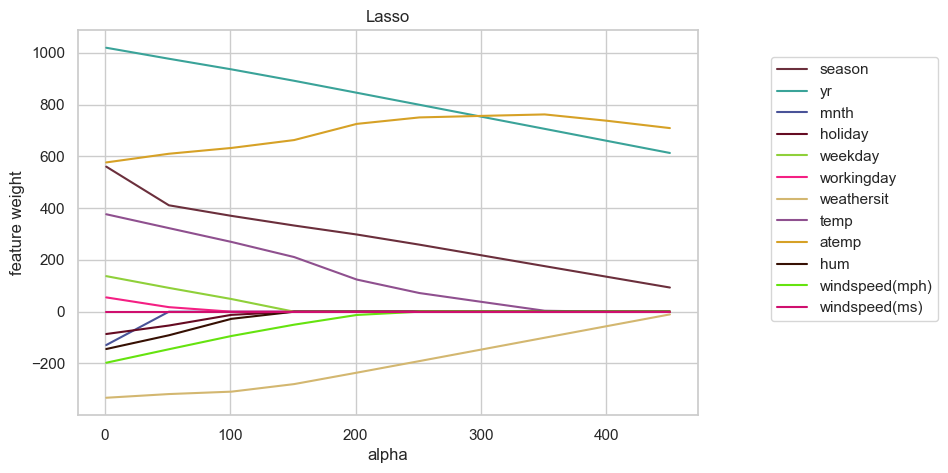

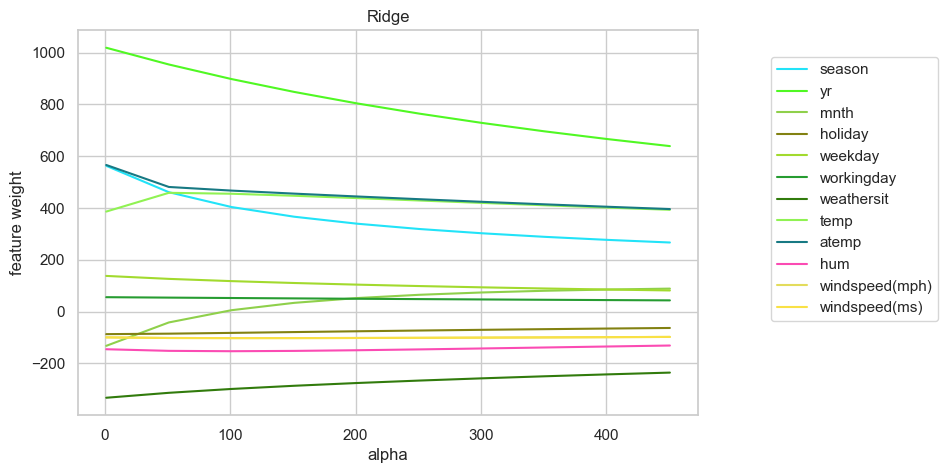

In [19]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
4. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповідь: 
1. Lasso
2. Ваги для деяких ознак можуть різко падати до нуля, тому що Lasso використовує L1-регуляризацію, яка схильна зануляти коефіцієнти деяких ознак. Величезне alpha створює занадто велике покарання для величини ваг, і модель вирішує, що жодна ознака не є достатньо важливою для передбачення, тому всі коефіцієнти стають нульовими.
3. Ні, сильно зменшує його коефіцієнт, але не виключає, так само як і Ridge. Тобто не виключає ознаки, а лише зменшує вагу цієї ознаки.
4. Lasso підійде для відбору неінформативних ознак. Оскільки Lasso має властивість зануляти коефіцієнти при певних значеннях alpha, він є ефективним для вибору важливих ознак і виключення менш значущих або неінформативних ознак.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [20]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Вибране значення alpha: 6
Пари ознака - коефіцієнт:
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


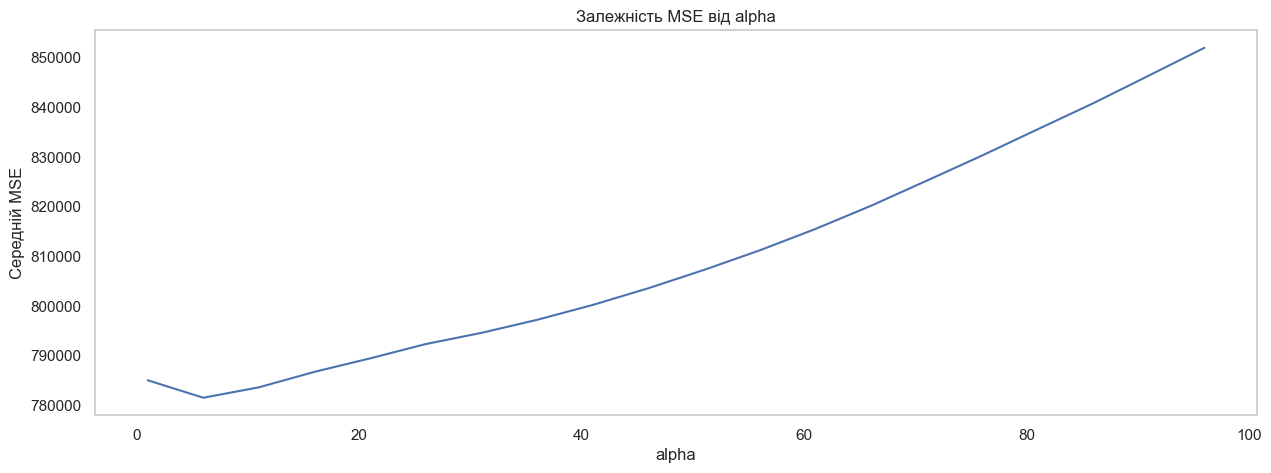

In [23]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, max_iter=10000)
regressor.fit(X, y)

print(f"Вибране значення alpha: {regressor.alpha_}")

# Виводимо пари "ознака - коефіцієнт"
print("Пари ознака - коефіцієнт:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

# Обчислюємо середнє значення MSE для кожного alpha
mse_values = np.mean(regressor.mse_path_, axis=1)  # Середнє значення MSE для кожного alpha

# Створюємо список даних для побудови графіка
dat = list(zip(regressor.alphas_, mse_values))

# Викликаємо функцію для побудови графіка
create_plot(dat, title="Залежність MSE від alpha", xlabel="alpha", ylabel="Середній MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.



Значення alpha для мінімуму MSE на кожному розбитті:
Розбиття 1: alpha = 6, MSE = 733725.7604052246
Розбиття 2: alpha = 1, MSE = 799433.1673691698
Розбиття 3: alpha = 51, MSE = 796979.8955193635


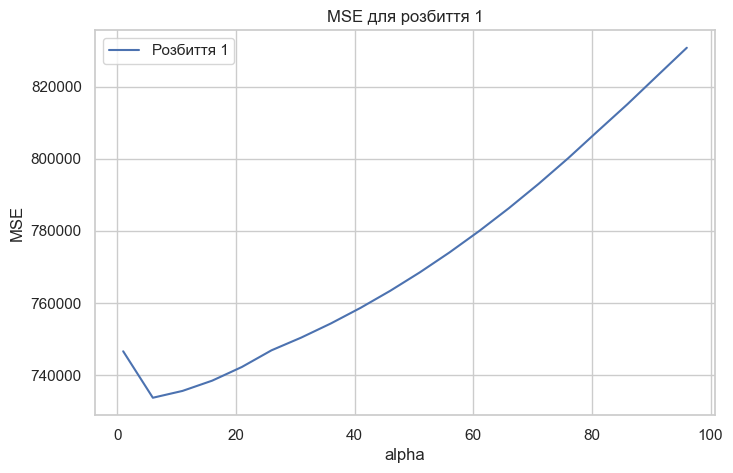

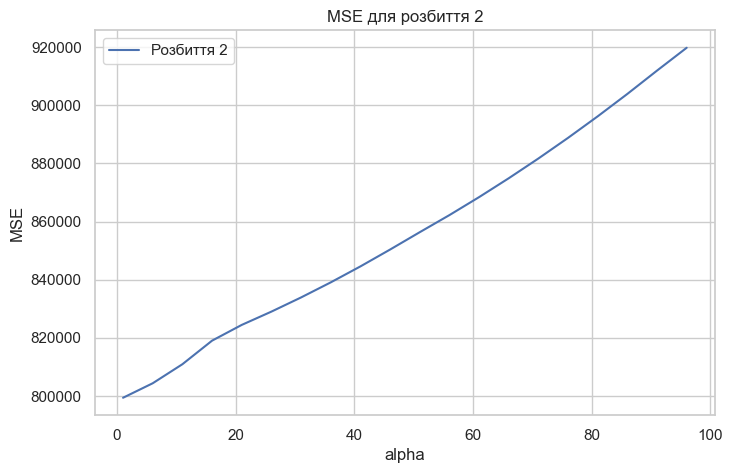

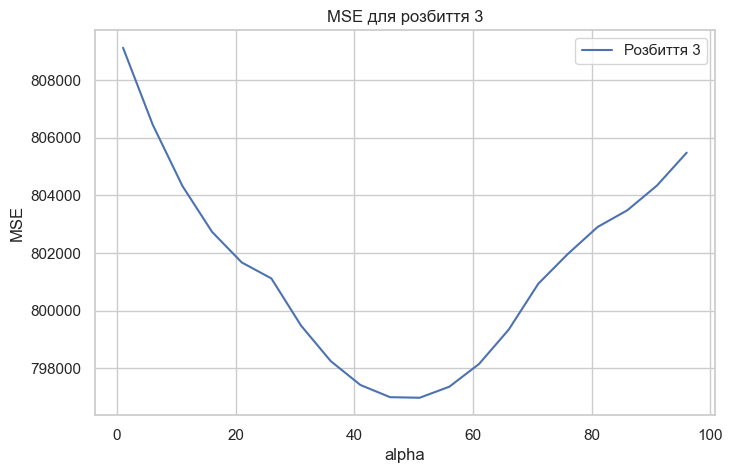

In [24]:
print("\nЗначення alpha для мінімуму MSE на кожному розбитті:")
for i in range(regressor.mse_path_.shape[1]):  # по кожному стовпцю (розбиттю)
    min_mse_index = np.argmin(regressor.mse_path_[:, i])  # Знаходимо індекс мінімуму в стовпці
    best_alpha = regressor.alphas_[min_mse_index]
    best_mse = regressor.mse_path_[min_mse_index, i] 
    print(f"Розбиття {i+1}: alpha = {best_alpha}, MSE = {best_mse}")


for i in range(regressor.mse_path_.shape[1]):  
    plt.figure(figsize=(8, 5))
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f"Розбиття {i+1}")
    plt.xlabel("alpha")
    plt.ylabel("MSE")
    plt.title(f"MSE для розбиття {i+1}")
    plt.grid(True)
    plt.legend()
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [75]:
#yr: 2014.0002115572445
#season: 490.3301596731828
#weekday: 68.52952121869997
#workingday: 109.15672016871201
#weathersit: -571.8227386312063
#atemp: 69.6661978336682

# Є зростаюча лінійна залежність.
# Виходячи зі здорового глузду, можна сказати що якщо ознака має безпосередній вплив на попит, то не завжди ознака впливає на позитивно на попит.
# Наприклад якщо температура вище, то вона комфортніща для катання на велосипеді і попит вище, в одночас, чим више швидкість вітру тим попит нижче. 

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [ ]:
#holiday: -311.10854773826867
#weathersit: -571.8227386312063
#windspeed(mph): -38.91771464825012

#Так, логічно стверджувати, що при високих значеннях цих ознак (свята, погана погода або сильний вітер) попит на велосипеди 
#може зменшуватися, оскільки ці фактори, ймовірно, знижують бажання людей використовувати велосипеди в таких умовах.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [ ]:
# windspeed(ms) (коефіцієнт: -0.0)
#Модель може вказувати, що windspeed(ms) не має істотного лінійного впливу на попит на велосипеди, але це не означає, 
#що в реальності цей фактор не може мати значення. Мабуть лінійна модель не змогла виявити цей вплив в даному наборі даних.
#До того ж є інша ознаки, яка містить подібну інформацію (windspeed(mph)), модель мабуть вибрала більш значущу ознаку і не 
#надала ваги швидкості вітру в метрах, яка має схожий вплив.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.